In [2]:
import nibabel as nib
import numpy as np
import os.path

from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.segment.mask import median_otsu


/home/patrykfi/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
root_path = "/user/pfilipia/home/inria/chu_nice_inria/patients_dmri/"

def get_file_prefix(patient_id):
    data_path = "patient%02d/bids/sub-patient%02d/ses-presurgical/proc/" % (patient_id, patient_id)
    data_file = "sub-patient%02d_ses-presurgical_dwi" % patient_id
    return os.path.join(root_path, data_path, data_file)

def get_dwi_file(patient_id):
    return get_file_prefix(patient_id) + '.nii.gz'

def get_bvals_file(patient_id):
    return get_file_prefix(patient_id) + '.bval'

def get_bvecs_file(patient_id):
    return get_file_prefix(patient_id) + '.bvec'


In [4]:
def load_data(patient_id):
    img = nib.load(get_dwi_file(patient_id))
    
    bvals, bvecs = read_bvals_bvecs(
        get_bvals_file(patient_id), get_bvecs_file(patient_id)
    )

    return img.get_data(), gradient_table(bvals, bvecs)


In [5]:
patient_id = 1
dwi_data, gtab = load_data(patient_id)

In [6]:
dwi_data_masked, brain_mask = median_otsu(dwi_data)


In [7]:
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response)
response, ratio = auto_response(
    gtab, dwi_data, roi_radius=10, fa_thr=0.7
)

In [8]:
csd_model = ConstrainedSphericalDeconvModel(gtab, response)

/home/patrykfi/anaconda3/lib/python3.5/site-packages/dipy/reconst/csdeconv.py:162: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r_sh = np.linalg.lstsq(self.B_dwi, self.S_r[self._where_dwi])[0]


In [9]:
from dipy.data import get_sphere

sphere = get_sphere('symmetric724')

In [10]:
from dipy.direction import peaks_from_model

csd_peaks = peaks_from_model(
    model=csd_model,
    data=dwi_data,
    sphere=sphere,
    mask=brain_mask,
    relative_peak_threshold=.5,
    min_separation_angle=25,
    parallel=True
)

/home/patrykfi/anaconda3/lib/python3.5/site-packages/dipy/reconst/csdeconv.py:586: UserWarning: maximum number of iterations exceeded - failed to converge
  warnings.warn(msg)
/home/patrykfi/anaconda3/lib/python3.5/site-packages/dipy/reconst/csdeconv.py:586: UserWarning: maximum number of iterations exceeded - failed to converge
  warnings.warn(msg)
/home/patrykfi/anaconda3/lib/python3.5/site-packages/dipy/reconst/csdeconv.py:586: UserWarning: maximum number of iterations exceeded - failed to converge
  warnings.warn(msg)


In [11]:
from dipy.reconst.dti import TensorModel

tensor_model = TensorModel(gtab, fit_method='WLS')
tensor_fit = tensor_model.fit(dwi_data, brain_mask)

fa = tensor_fit.fa


In [15]:
import pickle

pickle.dump( csd_peaks, open( "csd_peaks.p", "wb" ) )

In [16]:
from dipy.tracking.local import LocalTracking, ThresholdTissueClassifier
from dipy.tracking.streamline import Streamlines

tissue_classifier = ThresholdTissueClassifier(fa, 0.1)

In [17]:
s00_img = nib.load(root_path + "patient01/bids/sub-patient01/ses-presurgical/electrodes_local/dwi_s00_10mm_mask.nii")
s00_mask = s00_img.get_data()


In [18]:
s00_mask.shape

(256, 256, 96)

In [19]:
def add_spherical_roi(mask, center_x, center_y, center_z, diameter):

    radius = diameter / 2
    radius_sqr = radius * radius

    for z in np.arange(-radius, radius + 1):
        for y in np.arange(-radius, radius + 1):
            for x in np.arange(-radius, radius + 1):
                mask[int(center_x + x), int(center_y + y), int(center_z + z)] = x*x + y*y + z*z <= radius_sqr
                

In [32]:
generated_mask = np.zeros_like(s00_mask)
add_spherical_roi(generated_mask, 186, 71, 21, 11)

In [33]:
from dipy.tracking.utils import random_seeds_from_mask

seeds = random_seeds_from_mask(generated_mask, seeds_count=2)

In [34]:
streamline_generator = LocalTracking(csd_peaks, tissue_classifier, seeds, affine=np.eye(4), step_size=0.5)
streamlines = Streamlines(streamline_generator)

In [35]:
from dipy.viz import actor, window

ren = window.Renderer()
ren.add(actor.line(streamlines))
window.show(ren, size=(900, 900))

/home/patrykfi/anaconda3/lib/python3.5/site-packages/vtk/util/numpy_support.py:135: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/home/patrykfi/anaconda3/lib/python3.5/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


In [35]:
from nibabel.streamlines import save as save_trk
from nibabel.streamlines import Tractogram

save_trk(Tractogram(streamlines, affine_to_rasmm=s00_img.affine), 'det_streamlines.trk')


In [43]:
import numpy.linalg 
from nibabel.affines import apply_affine

affine_inv = numpy.linalg.inv(s00_img.affine)
apply_affine(affine_inv, [-56.18, -15.84, -16.33])

array([185.99965746,  70.99710345,  20.99925385])

NameError: name 'apply_affine' is not defined

/home/patrykfi/anaconda3/lib/python3.5/site-packages/dipy/core/histeq.py:22: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  histo, bins = np.histogram(arr.flatten(), num_bins, normed=True)


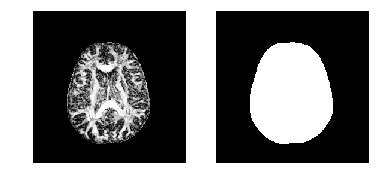

In [109]:
import matplotlib.pyplot as plt
from dipy.core.histeq import histeq

%matplotlib inline

sli = data.shape[2] // 2
plt.figure('Brain segmentation')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(histeq(csd_peaks.gfa[:, :, sli].astype('float')).T,
           cmap='gray', origin='lower')

plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(histeq(brain_mask[:, :, sli].astype('float')).T,
           cmap='gray', origin='lower')